In [36]:
import pandas as pd
import geopandas as gpd
import glob
import datetime

In [89]:
census = gpd.read_file("../data/raw/geo/census.shp")
census.head()

,TOT_REG_CD,ADM_NM,ADM_CD,geometry
0,1101053010006,사직동,1101053,"POLYGON ((953231.9682865143 1953435.865716934,..."
1,1101053010001,사직동,1101053,"POLYGON ((952858.5655841827 1952976.274114609,..."
2,1101053010003,사직동,1101053,"POLYGON ((952889.1776866913 1953405.245515823,..."
3,1101053010002,사직동,1101053,"POLYGON ((953093.8012866974 1953337.962316513,..."
4,1101053010005,사직동,1101053,"POLYGON ((953553.9324855804 1953335.741514206,..."


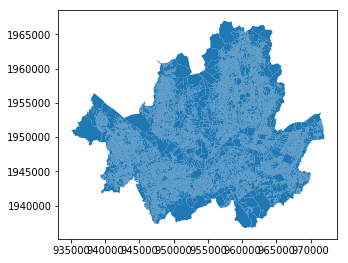

In [90]:
census.plot(figsize=(5,5))

# ped count data

look at one file

In [92]:
filename = "../data/raw/LOCAL_PEOPLE_20181005.csv"
ped = pd.read_csv(filename)
ped.head()

,기준일ID,시간대구분,행정동코드,집계구코드,총생활인구수,남자0세부터9세생활인구수,남자10세부터14세생활인구수,남자15세부터19세생활인구수,남자20세부터24세생활인구수,남자25세부터29세생활인구수,...,여자25세부터29세생활인구수,여자30세부터34세생활인구수,여자35세부터39세생활인구수,여자40세부터44세생활인구수,여자45세부터49세생활인구수,여자50세부터54세생활인구수,여자55세부터59세생활인구수,여자60세부터64세생활인구수,여자65세부터69세생활인구수,여자70세이상생활인구수
0,20181005,7,11260610,1107062010002,445.0,17,7,8,11,12,...,21,19,15,16,22,25,20,16,11,34
1,20181005,23,11260610,1107062010004,505.0,19,8,7,13,20,...,11,18,17,11,17,19,24,21,13,55
2,20181005,13,11260610,1107062010005,175.0,7,*,6,*,4,...,4,5,4,5,5,8,10,5,5,24
3,20181005,15,11440630,1114063040403,39.0,*,*,*,*,*,...,*,*,*,*,*,*,*,*,*,*
4,20181005,18,11140680,1102068010401,137.0,*,*,*,*,6,...,*,7,18,8,*,4,5,*,4,9


## Make one merged dataframe

let's pick "기준일ID", "시간대구분", "집계구코드", "총생활인구수" and rename it.

In [93]:
def get_ped_count(raw_file):
    ped = pd.read_csv(raw_file)[["기준일ID", "시간대구분", "집계구코드", "총생활인구수"]]
    ped.columns = ['date', 'time', 'census', 'ped_count']
    return ped

Make a list of ped count csvs

In [28]:
raw_ped_counts = glob.glob("../data/raw/LOCAL_PEOPLE_201809/*.csv")

apply get_ped_count function to the list

In [97]:
results = list(map(get_ped_count, raw_ped_counts))

Merge into one dataframe

In [98]:
ped_counts = pd.concat(results)

## Add timeslot and aggregate

find day of week from dates and make a timeslot column combining day and time

In [99]:
ped_counts['day'] = pd.to_datetime(ped_counts['date'], format='%Y%m%d').dt.dayofweek
ped_counts['timeslot'] = ped_counts['day'].map('D{}'.format).str.cat(ped_counts['time'].map('T{:02d}'.format))

In [100]:
ped_counts.head()

,date,time,census,ped_count,day,timeslot
0,20180917,15,1120071050005,1.0,0,D0T15
1,20180917,2,1107069020203,29.0,0,D0T02
2,20180917,18,1104068010006,23.0,0,D0T18
3,20180917,10,1120069010016,15.0,0,D0T10
4,20180917,14,1108083030005,157.0,0,D0T14


aggregate ped_count by timeslot

In [101]:
df = ped_counts.groupby(['census', 'timeslot'])\
.mean()[['ped_count']]\
.reset_index()

In [104]:
df.head()

,census,timeslot,ped_count
0,1101053010001,D0T00,311.25
1,1101053010001,D0T01,294.25
2,1101053010001,D0T02,284.00
3,1101053010001,D0T03,278.50
4,1101053010001,D0T04,208.75


In [106]:
df.to_csv("../data/interim/aggregated.csv", index=False)